In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from sklearn.decomposition import NMF
from importlib import reload
import wrapper
import trecs
import os
from scipy import sparse
from trecs.models import ContentFiltering
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn-paper")

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
ratings_df = pd.read_csv('data/ml-100k/u.data', sep="\t", names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

## Creating RecommenderSystem on MovieLens 

### Creating Embeddings

In [4]:
binary_ratings_df = ratings_df.drop(columns=['Timestamp'])
binary_ratings_df.loc[binary_ratings_df['Rating'] > 0, 'Rating'] = 1

# turn dataframe into matrix where each movie is a column and each user is a row
binary_ratings_matrix = binary_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).to_numpy()

In [5]:
n_attrs=100
max_iter=500

if not os.path.exists('artefacts/'):
    os.mkdir('artefacts/')

user_representation_file_path = f'artefacts/ml_user_representations_{max_iter}maxiter_{n_attrs}nAttrs.npy'
item_representation_file_path = f'artefacts/ml_item_representations_{max_iter}maxiter_{n_attrs}nAttrs.npy'
if not os.path.exists(user_representation_file_path) or not os.path.exists(item_representation_file_path):
    nmf = NMF(n_components=n_attrs, init='random', random_state=random_state, max_iter=max_iter)
    user_representation = nmf.fit_transform(binary_ratings_matrix)
    item_representation = nmf.components_
    np.save(user_representation_file_path, user_representation)
    np.save(item_representation_file_path, item_representation)
else:
    user_representation = np.load(user_representation_file_path)
    item_representation = np.load(item_representation_file_path)

print(user_representation.shape, item_representation.shape)

(943, 100) (100, 1682)


In [6]:
users = Users(actual_user_profiles=user_representation, repeat_interactions=False, attention_exp=1.5)

## Create Fair RS Model

In [7]:
# Define topic clusters using NMF
nmf_solver='mu'
n_clusters=50

topic_clusters_file_path = f'artefacts/ml_topic_clusters_{max_iter}maxiter_{nmf_solver}solver_{n_clusters}nClusters.npy'
if not os.path.exists(topic_clusters_file_path):
    item_topics = get_topic_clusters(binary_ratings_matrix, n_attrs=n_clusters, max_iter=max_iter, nmf_solver=nmf_solver)
    np.save(topic_clusters_file_path, item_topics)
else:
    item_topics = np.load(topic_clusters_file_path)

In [8]:
#TODO: Histogram of users per cluster

## Simulation

In [9]:
timesteps=50
user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]

mse = MSEMeasurement()
measurements_list = [
    InteractionMeasurement(), 
    mse,  
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    # TopicInteractionMeasurement(),
    MeanNumberOfTopics(),
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric()
]

In [10]:
def plot_measurements(measurements_df):

    fig, ax = plt.subplots(2, 3, figsize=(15, 6))
    fig.tight_layout(h_pad=3)

    measurements_df['rec_similarity'].plot(ax=ax[0, 0])
    measurements_df['interaction_similarity'].plot(ax=ax[0, 1])
    measurements_df['mean_num_topics'].plot(ax=ax[0, 2])
    measurements_df['serendipity_metric'].plot(ax=ax[1, 0])
    measurements_df['novelty_metric'].plot(ax=ax[1, 1])
    measurements_df['diversity_metric'].plot(ax=ax[1, 2])

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Recommendation similarity')
    ax[0, 0].set_ylabel('Similarity')
    
    ax[0, 1].set_title('Interaction Similarity')
    ax[0, 1].set_ylabel('Jaccard Similarity')

    ax[0, 2].set_title('Mean Number of Topics per User')
    ax[0, 2].set_ylabel('Mean Number of Topics per User')
    
    ax[1, 0].set_title('Serendipity')
    ax[1, 0].set_ylabel('Serendipity')
    
    ax[1, 1].set_title('Novelty')
    ax[1, 1].set_ylabel('Novelty')

    ax[1, 2].set_title('Diversity')
    ax[1, 2].set_ylabel('Diversity')

    

In [11]:
def plot_histograms(model, measurements_df):
    # for every 10 timesteps plot line in different color
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(10, timesteps+10, 10):
        ax[0].plot(np.arange(model.num_items), sorted(measurements_df['interaction_histogram'][i]), label=f't={i}')
        ax[1].plot(np.arange(model.num_items), sorted(measurements_df['topic_interaction_histogram'][i]), label=f't={i}')

    ax[0].set_title('Interaction Histogram')
    ax[0].set_xlabel('Items')
    ax[0].set_ylabel('# Interactions')
    ax[0].legend()
    # ax[1].set_title('Topic Interaction Similarity')
    # ax[1].set_xlabel('Topics')
    # ax[1].set_ylabel('# Interactions')
    # ax[1].legend()

In [12]:
def load_or_create_measurements_df(model, path):
    if os.path.exists(path):
        df = pd.read_csv(path, index_col=0)
    else:
        measurements = model.get_measurements()
        df = pd.DataFrame(measurements)
        df.to_csv(path)
    
    return df

### Fair Model

In [13]:
import trecs.matrix_ops as mo
import scipy.spatial as sp
from numpy.linalg import norm

def cosine_similarity_reranking(predicted_user_profiles, predicted_item_attributes):
    # Reranking
    alpha = 1
    predicted_scores = mo.inner_product(predicted_user_profiles, predicted_item_attributes)
    # create a vector that contains the norms of all row vectors in predicted_user_profiles
    user_norms = norm(predicted_user_profiles, axis=1)
    item_norms = norm(predicted_item_attributes, axis=0)

    # create a matrix that contains the outer product of user_norms and item_norms
    norms = np.outer(user_norms, item_norms)
    cosine_similarities = predicted_scores / norms
    cosine_similarities = np.nan_to_num(cosine_similarities)
    # print max value of norms
    re_ranked_scores = predicted_scores - alpha * cosine_similarities
    return re_ranked_scores

In [14]:
# Fair Model
fairsys = BubbleBurster(
    item_topics=item_topics,
    actual_item_representation=item_representation,
    num_attributes=n_attrs,
    actual_user_representation=users,
    record_base_state=True,
    score_fn=cosine_similarity_reranking,
)

fairsys.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {fairsys.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {fairsys.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


/opt/conda/envs/rsenv2/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [15]:
# Fair Model
fairsys.run(timesteps=timesteps)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [23:38<00:00, 28.37s/it]


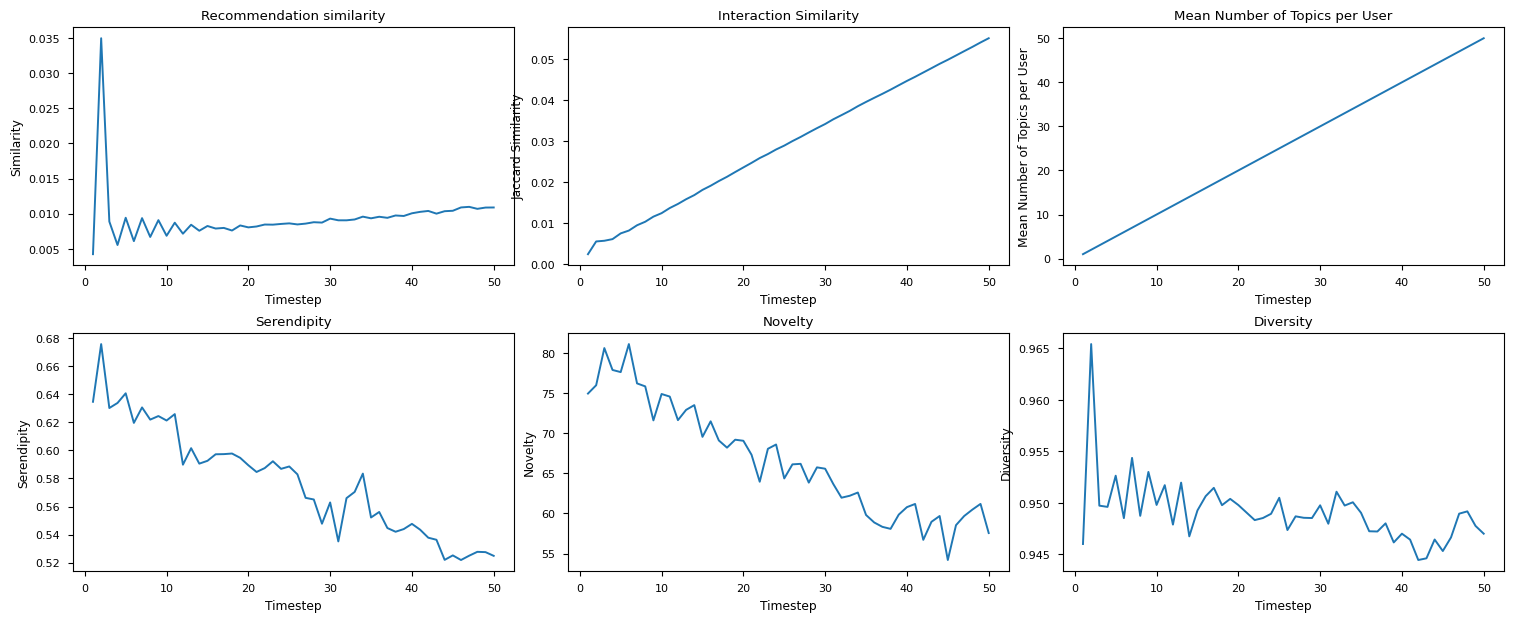

In [17]:
path = f'artefacts/fairsys_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs_{n_clusters}nClusters.csv'
fairsys_measurements_df = load_or_create_measurements_df(fairsys, path)
plot_measurements(fairsys_measurements_df)